# Aspect based sentiment analysis on matched pairs

## Notebook outline
    * Inspecting the ABSA results
    * Matching pairs
    * ABSA indicators
    * Confidence intervals for indicators
    * Impact of indicators on rating

In this notebook we use results from the notebook **absa_preparation.ipynb** and analyse it.

## Inspecting the ABSA results

In [107]:
# Useful imports
import pandas as pd
import seaborn as sns
import numpy as np
import random
import math
import statsmodels.formula.api as smf
import os.path
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
#absa_results = pd.read_csv('./datasets/results/results_aggregated.csv')
absa_results = pd.read_csv('../datasets/results/absa_results.csv')

In [3]:
# remove unnecessary column
absa_results = absa_results.drop('Text', axis=1)

In [98]:
features = absa_results.columns[1:]
positive_features = [feature for feature in features if 'Positive' in feature]
negative_features = [feature for feature in features if 'Negative' in feature]
neutral_features = [feature for feature in features if 'Neutral' in feature]
features

Index(['Appearance Positive', 'Appearance Neutral', 'Appearance Negative',
       'Aroma Positive', 'Aroma Neutral', 'Aroma Negative', 'Palate Positive',
       'Palate Neutral', 'Palate Negative', 'Taste Positive', 'Taste Neutral',
       'Taste Negative'],
      dtype='object')

Below we can see how the results look:

For each aspect (**Appearance**, **Aroma**, **Palate** and **Taste**) we got **probabilities** of textual sentiment being **positive**, **neutral** and **negative**.

In [5]:
# see how the results look
absa_results.head()

,Row Index,Appearance Positive,Appearance Neutral,Appearance Negative,Aroma Positive,Aroma Neutral,Aroma Negative,Palate Positive,Palate Neutral,Palate Negative,Taste Positive,Taste Neutral,Taste Negative
0,216,0.974481,0.005291,0.020228,0.982895,0.002254,0.014850,0.710195,0.022451,0.267354,0.633389,0.021023,0.345588
1,292,0.593674,0.215933,0.190393,0.493198,0.191977,0.314825,0.648823,0.206792,0.144386,0.502106,0.292476,0.205419
2,298,0.427067,0.377558,0.195375,0.702528,0.127771,0.169701,0.285166,0.687439,0.027395,0.994922,0.003798,0.001280
3,343,0.651201,0.049745,0.299054,0.911328,0.012691,0.075981,0.600418,0.066736,0.332846,0.583243,0.046122,0.370635
4,348,0.941425,0.023591,0.034984,0.998509,0.000367,0.001124,0.918099,0.031206,0.050695,0.881918,0.042310,0.075772


Next, we are going to plot our results to see if there are some differences between aspects.

**Note:** y axis are not in the same intervals. Since they differ by lot, we decided to present them this way.

<AxesSubplot:xlabel='Taste Positive', ylabel='Count'>

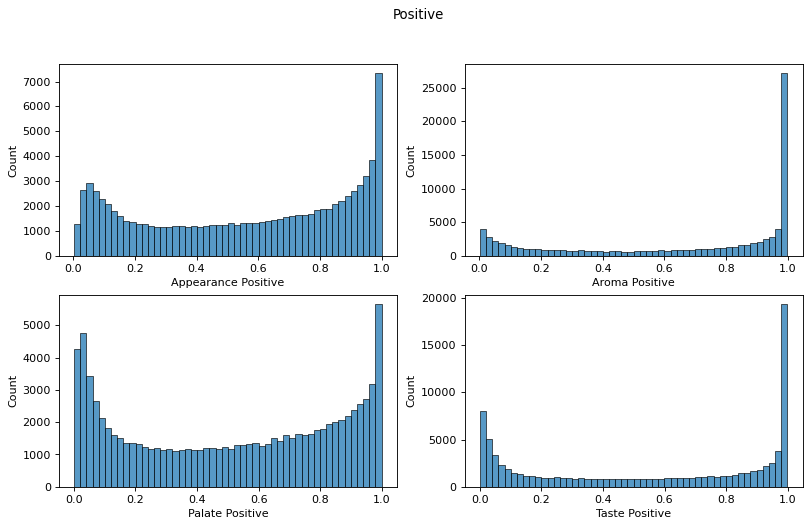

In [6]:
# plotting the positive sentiments
fig = plt.figure(figsize=(12,7), dpi=80)
plt.suptitle('Positive')
plt.subplot(221)
sns.histplot(absa_results['Appearance Positive'], bins=50)
plt.subplot(222)
sns.histplot(absa_results['Aroma Positive'], bins=50)
plt.subplot(223)
sns.histplot(absa_results['Palate Positive'], bins=50)
plt.subplot(224)
sns.histplot(absa_results['Taste Positive'], bins=50)

We see that **aroma** and **taste** have more reviews for which positive sentiment probability is highly confident (>0.9) than **appearance** and **palate** have.

<AxesSubplot:xlabel='Taste Negative', ylabel='Count'>

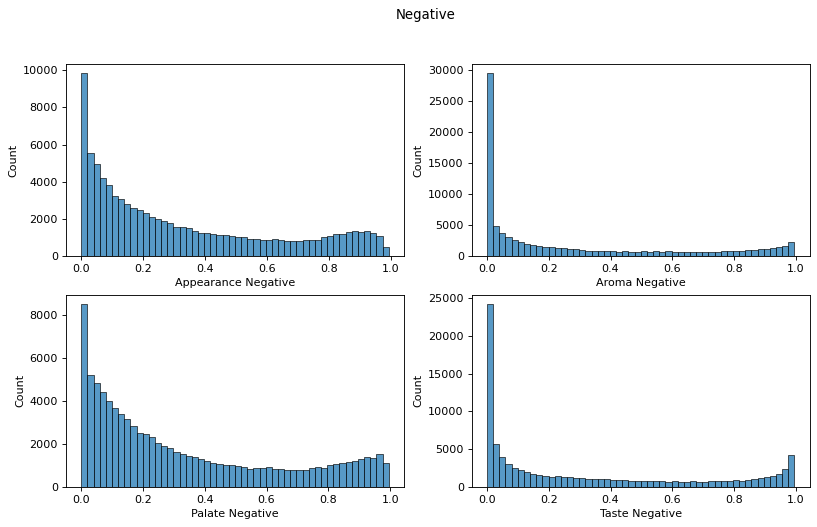

In [7]:
# plotting negative sentiment
fig = plt.figure(figsize=(12,7), dpi=80)
plt.suptitle('Negative')
plt.subplot(221)
sns.histplot(absa_results['Appearance Negative'], bins=50)
plt.subplot(222)
sns.histplot(absa_results['Aroma Negative'], bins=50)
plt.subplot(223)
sns.histplot(absa_results['Palate Negative'], bins=50)
plt.subplot(224)
sns.histplot(absa_results['Taste Negative'], bins=50)

Next, we see similar connection between **aroma** and **taste** for the negative aspects of reviews. There are many reviews for which we are sure that they are not negative, which is not the case for **appearance** and **palate**.

<AxesSubplot:xlabel='Taste Neutral', ylabel='Count'>

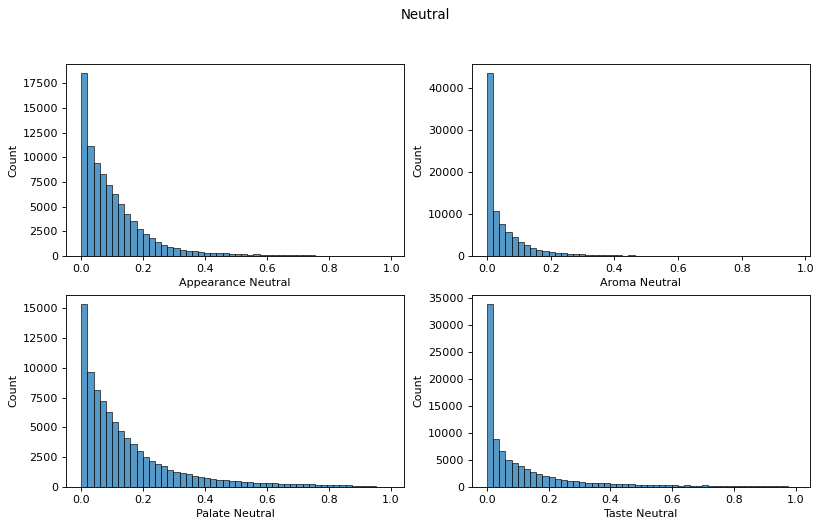

In [8]:
# plotting neutral sentiment
fig = plt.figure(figsize=(12,7), dpi=80)
plt.suptitle('Neutral')
plt.subplot(221)
sns.histplot(absa_results['Appearance Neutral'], bins=50)
plt.subplot(222)
sns.histplot(absa_results['Aroma Neutral'], bins=50)
plt.subplot(223)
sns.histplot(absa_results['Palate Neutral'], bins=50)
plt.subplot(224)
sns.histplot(absa_results['Taste Neutral'], bins=50)

Let's see what percentage of reviews are surely (with thresh 0.0005 on probability) not neutral:

In [9]:
thresh = 0.0005

neut_0_appearance = len(absa_results[absa_results['Appearance Neutral'] < thresh]) / len(absa_results)
neut_0_aroma = len(absa_results[absa_results['Aroma Neutral'] < thresh]) / len(absa_results)
neut_0_palate = len(absa_results[absa_results['Palate Neutral'] < thresh]) / len(absa_results)
neut_0_taste = len(absa_results[absa_results['Taste Neutral'] < thresh]) / len(absa_results)

print("Percentage of [ Appearance Neutral < {} ] reviews: {:.4f}".format(thresh, neut_0_appearance * 100))
print("Percentage of [ Aroma Neutral < {} ] reviews: {:.4f}".format(thresh, neut_0_aroma * 100))
print("Percentage of [ Palate Neutral < {} ] reviews: {:.4f}".format(thresh, neut_0_palate * 100))
print("Percentage of [ Taste Neutral < {} ] reviews: {:.4f}".format(thresh, neut_0_taste * 100))

# They are least neutral towards AROMA and also, TASTE has a non-negligible score

Percentage of [ Appearance Neutral < 0.0005 ] reviews: 0.2134
Percentage of [ Aroma Neutral < 0.0005 ] reviews: 11.1631
Percentage of [ Palate Neutral < 0.0005 ] reviews: 0.0968
Percentage of [ Taste Neutral < 0.0005 ] reviews: 3.2946


Below we see that users are almost always positive when they are not neutral when it comes to **aroma**!

In [10]:
# Average grade for Aroma Positive (approx. 1 - Aroma Negative) when Aroma Neutral < thresh
percentage_positive = absa_results[absa_results['Aroma Neutral'] < thresh]['Aroma Positive'].mean()
print("Percentage of positive ratings of aroma if we are not neutral: {}".format(100*percentage_positive))

Percentage of positive ratings of aroma if we are not neutral: 99.82676229000813


## Matching pairs

Now, we will repeat the process of matching pairs, but this time we will include the results of aspect based sentiment analysis.

In [11]:
# Loading in the data
#reviews = pd.read_pickle('./datasets/BeerAdvocate/reviews.pkl')
reviews = pd.read_pickle('../datasets/BeerAdvocate/reviews.pkl')
print(reviews.shape)

(2589587, 17)


In [12]:
# setting constants
matched_text_difference = 100
maximum_text_size = 2000

winter_months = [1, 2, 3]
spring_months = [4, 5, 6]
summer_months = [7, 8, 9]
autumn_months = [10, 11, 12]

In [13]:
# setting row index as a column - useful later
reviews['Row Index'] = reviews.index

In [14]:
# selecting necessary columns
reviews_clean = reviews[['Beer Id','Brewery Id','Style','Abv','Date','User Id','Appearance','Aroma',\
                         'Palate','Taste','Overall','Rating','Text', 'Row Index']]

In [15]:
# merging absa results
reviews_clean = reviews_clean.merge(absa_results, on='Row Index')

In [16]:
# matching on User Id, Style and Abv
reviews_cartesian = reviews_clean.merge(reviews_clean, on=['User Id','Style','Abv'], suffixes=('1', '2'))

In [17]:
# filtering pairs where first one is absolutely better
reviews_pairs = reviews_cartesian[(reviews_cartesian['Rating1'] > reviews_cartesian['Rating2']) & \
                                  (reviews_cartesian['Overall1'] > reviews_cartesian['Overall2']) & \
                                  (reviews_cartesian['Aroma1'] > reviews_cartesian['Aroma2']) & \
                                  (reviews_cartesian['Appearance1'] > reviews_cartesian['Appearance2']) & \
                                  (reviews_cartesian['Taste1'] > reviews_cartesian['Taste2']) & \
                                  (reviews_cartesian['Palate1'] > reviews_cartesian['Palate2'])].copy()

In [18]:
# adding month columns to filtered data
reviews_pairs['Month1'] = reviews_pairs['Date1'].apply(lambda x: x.month)
reviews_pairs['Month2'] = reviews_pairs['Date2'].apply(lambda x: x.month)
reviews_pairs['Text Length1'] = reviews_pairs['Text1'].apply(len)
reviews_pairs['Text Length2'] = reviews_pairs['Text2'].apply(len)

In [19]:
# matching pairs on seasonality
seasonal_pairs = reviews_pairs[
            ((reviews_pairs['Month1'].isin(winter_months) & reviews_pairs['Month2'].isin(winter_months)) | \
             (reviews_pairs['Month1'].isin(spring_months) & reviews_pairs['Month2'].isin(spring_months)) | \
             (reviews_pairs['Month1'].isin(summer_months) & reviews_pairs['Month2'].isin(summer_months)) | \
             (reviews_pairs['Month1'].isin(autumn_months) & reviews_pairs['Month2'].isin(autumn_months)))
                              ]

In [20]:
matched_len_reviews_pairs = seasonal_pairs[abs(seasonal_pairs['Text Length1'] - \
                                               seasonal_pairs['Text Length2']) < matched_text_difference]

In [21]:
long_reviews = matched_len_reviews_pairs[(matched_len_reviews_pairs['Text Length1']> maximum_text_size) | \
                                           (matched_len_reviews_pairs['Text Length2']> maximum_text_size)]

In [22]:
matched_pairs = matched_len_reviews_pairs.drop(index = long_reviews.index)

In [23]:
winter_pairs = matched_pairs[matched_pairs['Month1'].isin(winter_months)].copy()
spring_pairs = matched_pairs[matched_pairs['Month1'].isin(spring_months)].copy()
summer_pairs = matched_pairs[matched_pairs['Month1'].isin(summer_months)].copy()
autumn_pairs = matched_pairs[matched_pairs['Month1'].isin(autumn_months)].copy()

print('Matched winter review pairs shape: {}'.format(winter_pairs.shape))
print('Matched spring review pairs shape: {}'.format(spring_pairs.shape))
print('Matched summer review pairs shape: {}'.format(summer_pairs.shape))
print('Matched autumn review pairs shape: {}'.format(autumn_pairs.shape))

Matched winter review pairs shape: (14757, 53)
Matched spring review pairs shape: (19234, 53)
Matched summer review pairs shape: (14375, 53)
Matched autumn review pairs shape: (13591, 53)


When we have our pairs with the results of aspect based sentiment analysis we are going to explore more.

## ABSA indicators

What is the case with textual analysis? 

Well, in order to see the importance, we will create **indicators** for each aspect in text for **better in a pair**. If the ABSA tool gave probability higer than 0.9 we will set indicator to 1, otherwise 0.

In [85]:
for feature in features:
    matched_pairs[feature + '1'] = 1*(matched_pairs[feature + '1'] > 0.9)
    matched_pairs[feature + '2'] = 1*(matched_pairs[feature + '2'] > 0.9)

In [86]:
indicators_positive = []
for feature in positive_features:
    indicators_positive.append(matched_pairs[feature + '1'].sum())

<AxesSubplot:>

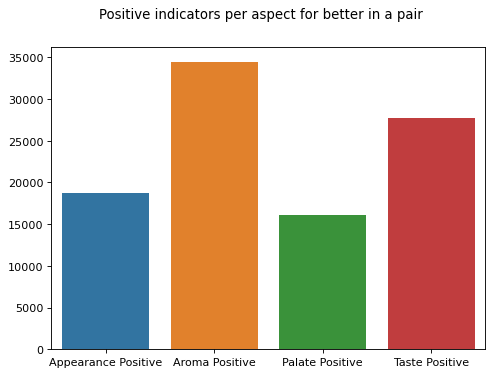

In [91]:
fig = plt.figure(figsize=(7,5), dpi=80)
plt.suptitle('Positive indicators per aspect for better in a pair')
sns.barplot(x=positive_features, y=indicators_positive)

We can see that **aroma** and **taste** have more positive indicators than **appearance** and **palate**.

In [92]:
indicators_negative = []
for feature in negative_features:
    indicators_negative.append(matched_pairs[feature + '1'].sum())

<AxesSubplot:>

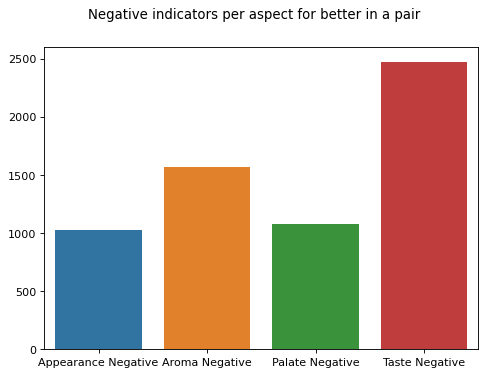

In [93]:
fig = plt.figure(figsize=(7,5), dpi=80)
plt.suptitle('Negative indicators per aspect for better in a pair')
sns.barplot(x=negative_features, y=indicators_negative)

## Confidence intervals for indicators

We have only inspected better reviews. Next, we will calculate **confidence intervals** for difference between indicators **between better and worse reviews** in order to see if there are some differences there.

In [95]:
# Task 3.8 : Helper function for confidence intervals

# confidence interval for data returned as : average, lower bound, upper bound
# boot count is number of data points tosample
def confidence_interval(data, boot_count=1000):
    # generating samples from data, boot_count times generate subsamples of length equal to the length of data
    boot_data = np.mean(np.random.choice(data, size=(boot_count, len(data)), replace=True), axis=1)
    
    # calculating average
    avg = np.mean(boot_data)
    
    # calculating boundaries for confidence interval
    [lo,hi] = np.percentile(boot_data,[2.5, 97.5])
    return avg, lo, hi

In [96]:
# helper function for analysing absa effects
def absa_effects(df, features, boot_count=1000):
    # initialize dictionary keys with headline effects 
    boot_effects = {}
    boot_effects.update({key : np.zeros(3) for key in features})
    
    for key in boot_effects:
        boot_effects[key] = confidence_interval(df[key+'1']-df[key+'2'])
    
    return boot_effects

In [99]:
boot_effects_positive = absa_effects(matched_pairs, positive_features)
boot_effects_negative = absa_effects(matched_pairs, negative_features)
boot_effects_neutral = absa_effects(matched_pairs, neutral_features)

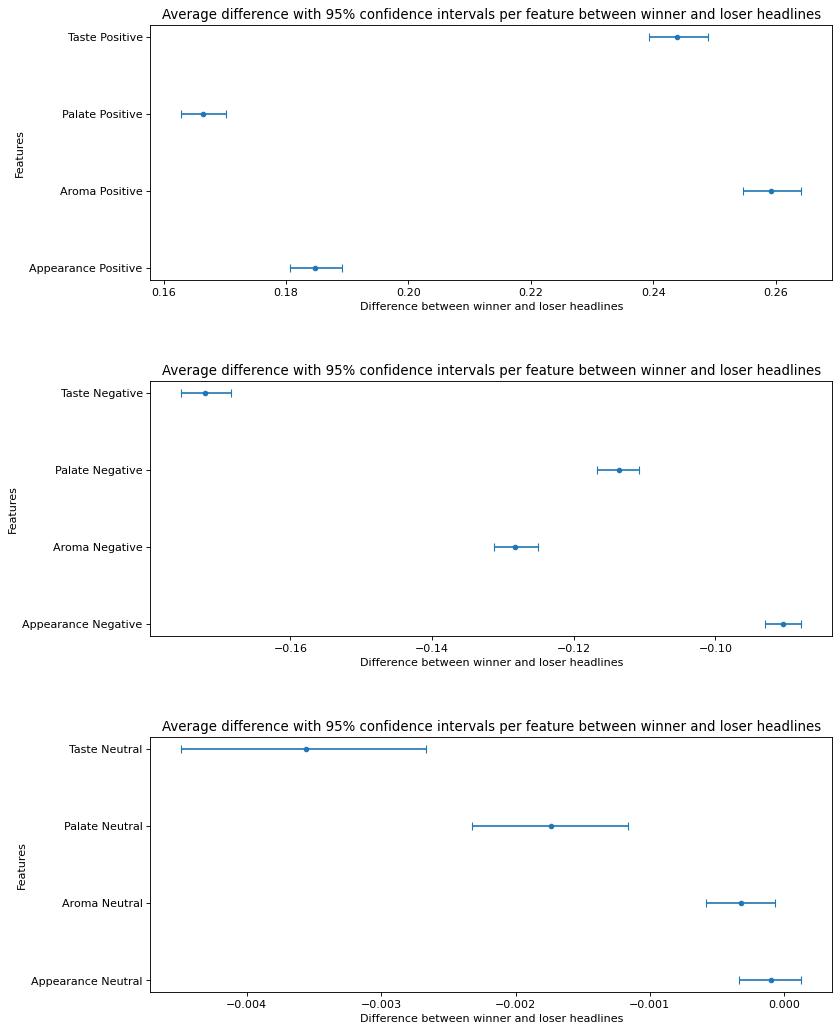

In [103]:
# create dataframe from dictionary of data
boot_effects_dataframe_negative = pd.DataFrame.from_dict(data=boot_effects_negative, orient='index', columns=['average_difference', '2.5%', '97.5%'])
boot_effects_dataframe_positive = pd.DataFrame.from_dict(data=boot_effects_positive, orient='index', columns=['average_difference', '2.5%', '97.5%'])
boot_effects_dataframe_neutral = pd.DataFrame.from_dict(data=boot_effects_neutral, orient='index', columns=['average_difference', '2.5%', '97.5%'])


# calculating errors between mean and confidence intervals boundaries
errors_negative = [boot_effects_dataframe_negative['average_difference'] -boot_effects_dataframe_negative['2.5%'], \
          boot_effects_dataframe_negative['97.5%'] - boot_effects_dataframe_negative['average_difference']]

errors_positive = [boot_effects_dataframe_positive['average_difference'] -boot_effects_dataframe_positive['2.5%'], \
          boot_effects_dataframe_positive['97.5%'] - boot_effects_dataframe_positive['average_difference']]

errors_neutral = [boot_effects_dataframe_neutral['average_difference'] -boot_effects_dataframe_neutral['2.5%'], \
          boot_effects_dataframe_neutral['97.5%'] - boot_effects_dataframe_neutral['average_difference']]

# plot the results
plt.figure(figsize=(11, 16), dpi=80)

plt.subplot(311)
plt.title('Average difference with 95% confidence intervals per feature between winner and loser headlines')
plt.xlabel('Difference between winner and loser headlines')
plt.ylabel('Features')
plt.errorbar(y=boot_effects_dataframe_positive.index, x=boot_effects_dataframe_positive['average_difference'], xerr=errors_positive,\
             fmt="o", markersize=4, capsize=4)

plt.subplot(312)
plt.title('Average difference with 95% confidence intervals per feature between winner and loser headlines')
plt.xlabel('Difference between winner and loser headlines')
plt.ylabel('Features')
plt.errorbar(y=boot_effects_dataframe_negative.index, x=boot_effects_dataframe_negative['average_difference'], xerr=errors_negative,\
             fmt="o", markersize=4, capsize=4)

plt.subplot(313)
plt.title('Average difference with 95% confidence intervals per feature between winner and loser headlines')
plt.xlabel('Difference between winner and loser headlines')
plt.ylabel('Features')
plt.errorbar(y=boot_effects_dataframe_neutral.index, x=boot_effects_dataframe_neutral['average_difference'], xerr=errors_neutral,\
             fmt="o", markersize=4, capsize=4)

# vertical line through zero as a reference for no effect
#plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.subplots_adjust(hspace=0.4)
plt.show()

From the plots above we conclude following:

As expected **all the intervals for positive/negative aspect difference are positive/negative**. That means that better reviews really have more positive and less negative indicators for aspects. But that was expected.

However, for positive indicators. we see that **aroma** and **taste** stand out as their confidence intervals are shifted to the right. That means that they are more often a better indicator if a review is better than **palate** and **appearance**. Maybe we could say that they are more *impactful*.

For negative indicators, **taste** seems to stand out as most important.

So, even though grades users give for ratings are pretty similar, they do not appear to be like that when it comes to textual aspect based sentiment analysis.

## Impact of indicators on rating

For instance, let's see the average grades of better and worse in a pair.

In [24]:
matched_pairs[['Aroma1', 'Taste1', 'Appearance1', 'Palate1']].mean()

Aroma1         4.069823
Taste1         4.112489
Appearance1    4.105912
Palate1        4.070618
dtype: float64

In [25]:
matched_pairs[['Aroma2', 'Taste2', 'Appearance2', 'Palate2']].mean()

Aroma2         3.287534
Taste2         3.262182
Appearance2    3.422866
Palate2        3.282527
dtype: float64

We can see that they are quite similar, only **appearance** stands out for worse reviews.

Let's see how indicators impact the grades:

We will se how **positive indicators** of a **better review** impact its rating and how **negative indicators** of a **worse comment** impact its rating.

In [108]:
lin_reg_data = {'rating' : matched_pairs['Rating1'],
                'aroma': matched_pairs['Aroma Positive1'],
                'taste': matched_pairs['Taste Positive1'],
                'appearance': matched_pairs['Appearance Positive1'],
                'palate': matched_pairs['Palate Positive1']
               }

model = smf.ols(formula='rating ~ aroma + taste + palate + appearance', data=lin_reg_data).fit()

model_summary = model.summary()

print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     1034.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:06:20   Log-Likelihood:                -40041.
No. Observations:               61957   AIC:                         8.009e+04
Df Residuals:                   61952   BIC:                         8.014e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9638      0.003   1325.641      0.0

From the results we see that **aspects similarly** impact the grade. Maybe the apperance is a little bit lower, but coefficients assigned to aspects do **not differ by much**.

Now, let's see the results for worse reviews and imact of negative indicators on them.

In [109]:
lin_reg_data = {'rating' : matched_pairs['Rating2'],
                'aroma': matched_pairs['Aroma Negative2'],
                'taste': matched_pairs['Taste Negative2'],
                'appearance': matched_pairs['Appearance Negative2'],
                'palate': matched_pairs['Palate Negative2']
               }

model = smf.ols(formula='rating ~ aroma + taste + palate + appearance', data=lin_reg_data).fit()

model_summary = model.summary()

print(model_summary)

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     4008.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:06:48   Log-Likelihood:                -56222.
No. Observations:               61957   AIC:                         1.125e+05
Df Residuals:                   61952   BIC:                         1.125e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4541      0.003   1246.740      0.0

We see that again, **aroma** and **taste** appear to be the most impactful. If there is a negative indicator of that sentiment, it will degrade the rating by 0.35!